# Kaggle Competition Intel & MobileODT Cervical Cancer Screening
Creating CNN model with Keras and TensorFlow. The data has already been placed into a numpy file.

In [1]:
pip install piexif

Note: you may need to restart the kernel to use updated packages.


In [47]:
import numpy as np
import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import plotly.graph_objs as go



from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import Callback
from keras import regularizers
from keras import optimizers


import glob

import os
import piexif
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import sys

In [82]:
#Images are going to be square so set size to 32 to be used for both width and height.
img_size = 32
train_dir = r"C:\Users\akaab\Desktop\intel-mobileodt-cervical-cancer-screening\train\train"
test_dir =  r"C:\Users\akaab\Desktop\intel-mobileodt-cervical-cancer-screening\test\test"

In [83]:
#uplaoding the images, counting the number of images for each type
training_directory = 'train'


type1_directory = os.path.join(train_dir, r'C:\Users\akaab\Desktop\intel-mobileodt-cervical-cancer-screening\train\train\Type_1')
type2_directory = os.path.join(train_dir, r'C:\Users\akaab\Desktop\intel-mobileodt-cervical-cancer-screening\train\train\Type_2')
type3_directory = os.path.join(train_dir, r'C:\Users\akaab\Desktop\intel-mobileodt-cervical-cancer-screening\train\train\Type_3')

train_type1_files = glob.glob(type1_directory+'/*.jpg')
train_type2_files = glob.glob(type2_directory+'/*.jpg')
train_type3_files = glob.glob(type3_directory+'/*.jpg')

print(len(train_type1_files))
print(len(train_type2_files))
print(len(train_type3_files))

250
781
450


In [84]:
# create dataframe of file and labels
files = {'filepath': train_type1_files + train_type2_files + train_type3_files,
          'label': ['Type 1']* len(train_type1_files) + ['Type 2']* len(train_type2_files) + ['Type 3']* len(train_type3_files)}

files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
files_df

,filepath,label
0,C:\Users\akaab\Desktop\intel-mobileodt-cervica...,Type 1
1,C:\Users\akaab\Desktop\intel-mobileodt-cervica...,Type 2
2,C:\Users\akaab\Desktop\intel-mobileodt-cervica...,Type 1
3,C:\Users\akaab\Desktop\intel-mobileodt-cervica...,Type 3
4,C:\Users\akaab\Desktop\intel-mobileodt-cervica...,Type 2
...,...,...
1476,C:\Users\akaab\Desktop\intel-mobileodt-cervica...,Type 2
1477,C:\Users\akaab\Desktop\intel-mobileodt-cervica...,Type 2
1478,C:\Users\akaab\Desktop\intel-mobileodt-cervica...,Type 3
1479,C:\Users\akaab\Desktop\intel-mobileodt-cervica...,Type 1


In [85]:
# get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,Num_Values
Type 2,781
Type 3,450
Type 1,250


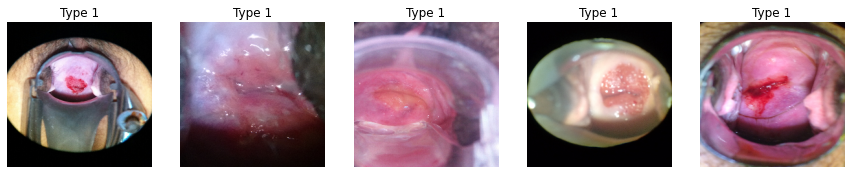

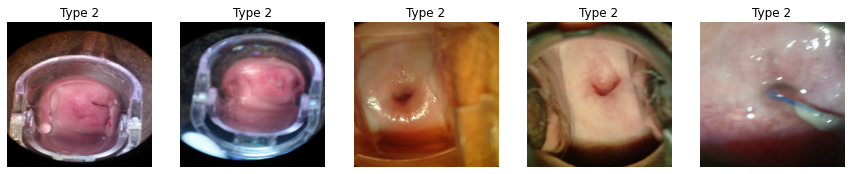

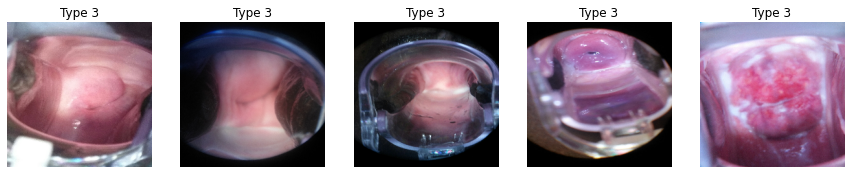

In [86]:
# display sample images of all types
for label in ('Type 1', 'Type 2', 'Type 3'):
    filepaths = files_df[files_df['label']==label]['filepath'].values[:5]
    fig = plt.figure(figsize= (15, 6))
    for i, path in enumerate(filepaths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (224, 224))
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        plt.subplots_adjust(hspace=0.5)
        plt.axis(False)
        plt.title(label)

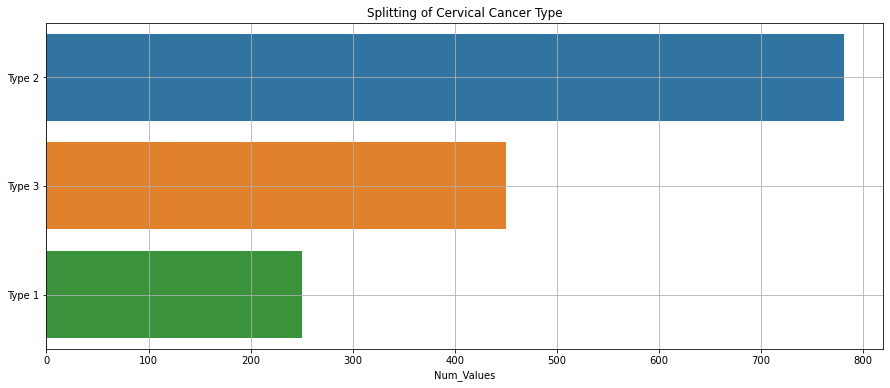

In [87]:
plt.figure(figsize = (15, 6))
sns.barplot(x= type_count['Num_Values'], y= type_count.index.to_list())
plt.title('Splitting of Cervical Cancer Type')
min([], default="EMPTY")
plt.grid(True)
plt.show()

In [88]:
# display pieplot of label distribution
pie_plot = go.Pie(labels= type_count.index.to_list(), values= type_count.values.flatten(),
                 hole= 0.2, text= type_count.index.to_list(), textposition='auto')
fig = go.Figure([pie_plot])
fig.update_layout(title_text='Pie Plot of Type Distribution')
fig.show()

In [89]:
def PreProcess_Images(root, train=True):
    features = []
    labels = []
    
    for subdir, dirs, files in os.walk(root):
        count  = 0
        for file in files:
            tot_files = len(files)
            if not file == ".DS_Store":
                count += 1
                sys.stdout.write("\rFile = " + file + " ----- Progress: {:2.1f}%".format(100 * count/float(tot_files)))
                img = os.path.join(subdir, file)
                #Remove exif data - This is because there is a lot of corrupt exif data in this dataset.
                if os.stat(img).st_size > 0:
                    piexif.remove(img)
                else:
                    continue
                #Open image and resize to designated width and height. 
                im = cv2.imread(img)
                im = cv2.resize(im, (img_size, img_size))
                #Extract features into a numpy array.
                feature = np.array(im, dtype=np.float32)
                #append feature to features list.
                features.append(feature)
                
                #only apply labels for training data. 
                if train == True:
                    #Get label from directory name.
                    label = os.path.basename(subdir)
                    #One hot encoding of label names.
                    if label == "1":
                        label = [1,0,0]
                    elif label == "2":
                        label = [0,1,0]
                    else:
                        label = [0,0,1]
                    #append label to labels list.    
                    labels.append(label)
                #add image filename to labels to be used in formatting of submission data.
                else:
                    label = os.path.basename(img)
                    labels.append(label)
                sys.stdout.flush()
    
    if train == True:
        labels = np.array(labels, np.uint8)
        
    features = np.array(features, np.float32) / 255.
    
    return features, labels

In [91]:
#Get Training X and y lists.
X, y = PreProcess_Images(train_dir, train=True)

File = 996.jpg ----- Progress: 100.0%

In [92]:
#Get test X and filenames of test images
X_test, flnm_test = PreProcess_Images(test_dir, train=False)

File = 99.jpg ----- Progress: 100.0%

In [93]:
#Split training data into training and validation data.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [94]:
#Save all information to a numpy archive file to be used when training the model.
np.savez('data_arrays', X_train, y_train, X_valid, y_valid, X_test, flnm_test)

In [95]:
def SummaryGraphs(hist):
    # summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [96]:
def Submission(mod, img_names, test_imgs):
    #Create Prediction File(.csv)
    test_predictions = mod.predict(test_imgs, batch_size=32, verbose=0)
    test_data = np.column_stack((img_names,test_predictions))
    dfPreds = pd.DataFrame(data=test_data,columns=['image_name','Type_1','Type_2','Type_3'])
    dfPreds.to_csv('submission_SID1738483.csv', index=False)

In [97]:
def QuickModel(learning_rate, opt_momentum, opt_decay, dropout):
    #Quick Keras Model
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(32,32,3)))
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(Dropout(dropout))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
    model.add(Dropout(dropout))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=learning_rate, momentum=opt_momentum, decay=opt_decay),
                  metrics=['accuracy']
                 )
    return model

In [98]:
def Train(learning_rate, momentum, decay, dropout, epochs, batch_size, slice_size, xtrain, ytrain, xval, yval, logging=0, graph=False):
    #Model
    model = QuickModel(learning_rate, momentum, decay, dropout)

    #Fit Model and save results to history for graphing later.
    history = model.fit(xtrain[:slice_size], ytrain[:slice_size],
              batch_size=batch_size,
              epochs=epochs,
              verbose=logging,
              validation_data=(xval[:slice_size], yval[:slice_size]))
    if graph == True:
        SummaryGraphs(history)
    return model

In [99]:
#Extract Data for training and testing from the .npz file.
with np.load('data_arrays.npz') as data:
    xtr = data['arr_0']
    ytr = data['arr_1']
    xvl = data['arr_2']
    yvl = data['arr_3']
    xts = data['arr_4']
    yts = data['arr_5']



Checking the loss
   

In [100]:
from tensorflow.keras import optimizers

Train(learning_rate=0.0, momentum=0.0, decay=0.0, dropout=0.0, epochs=1, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=1)

C:\Users\akaab\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



10/10 [==============================] - 3s 282ms/step - loss: 1.0818 - accuracy: 0.2686 - val_loss: 1.0813 - val_accuracy: 0.2896


   * As we can see the inital model training loss is pretty close to what we expect.

Increasing dropout rate

In [101]:
Train(learning_rate=0.0, momentum=0.0, decay=0.0, dropout=0.5, epochs=1, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=1)

10/10 [==============================] - 4s 346ms/step - loss: 1.1205 - accuracy: 0.2838 - val_loss: 1.1197 - val_accuracy: 0.0000e+00


Setting the dropout (regularization) to 0

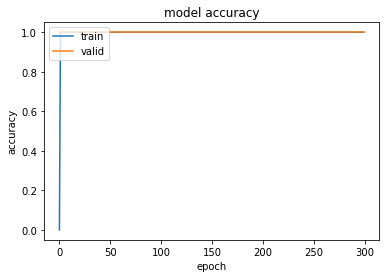

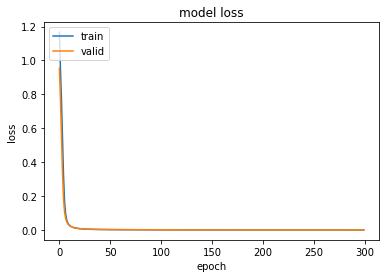

In [102]:
Train(learning_rate=0.01, momentum=0.0, decay=0.0, dropout=0.0, epochs=300, 
      batch_size=128, slice_size=10, xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

# Training
Changing hyperparameters to find the best model

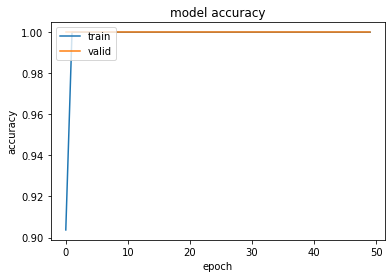

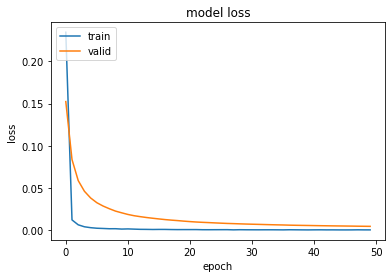

In [103]:
model = Train(learning_rate=0.01, momentum=0.0, decay=0.0, dropout=0.5, epochs=50, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

Increasing the learning rate

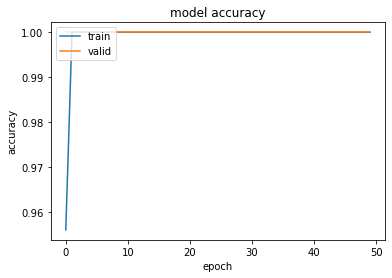

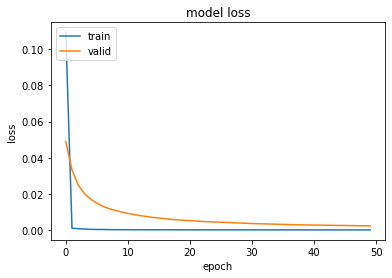

In [104]:
model = Train(learning_rate=0.05, momentum=0.0, decay=0.0, dropout=0.5, epochs=50, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

Decreasing the learning rate, increasing the epochs and adding momentum.

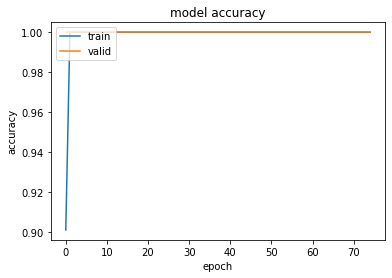

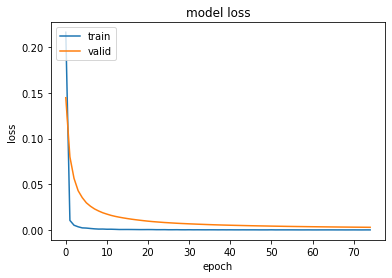

In [105]:
model = Train(learning_rate=0.01, momentum=0.01, decay=0.0, dropout=0.5, epochs=75, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

........

Final model after changing the hyperparameters

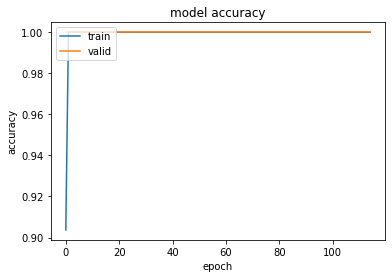

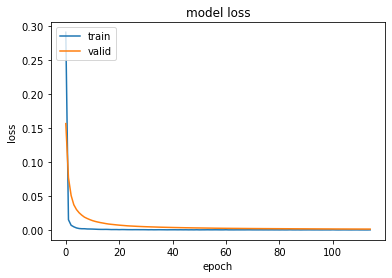

In [106]:
model = Train(learning_rate=0.01, momentum=0.01, decay=0.0, dropout=0.5, epochs=115, 
      batch_size=128, slice_size=len(xtr), xtrain=xtr, ytrain=ytr, xval=xvl, yval=yvl, logging=0, graph=True)

Creating submission file for Kaggle

In [107]:
Submission(model, yts, xts)

This model had a logloss of 0.91613 on the test data in the Kaggle submission.